<a href="https://colab.research.google.com/github/shecheeyee/PyTorch_learning/blob/main/01_pytorch_workflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PyTorch Workflow




PyTorch end-to-end workflow:

1. data (prepare and load)
2. build model
3. fitting model to data (training)
4. making predictions and evaluating model
5. saving and loading a model
6. all together

In [ ]:
import torch
from torch import nn #all neural network stuff
import matplotlib.pyplot as plt

# check pytorch ver
torch.__version__

'1.13.1+cu116'

## 1. Data (prep and loading)

* Excel spreadsheet
* Images
* Videos
* Audio
* DNA
* Text

Machine Learning consists of:
1. Get data into a numerical representation
2. Build a model to learn patterns in that numerical representation

Using a LR to make a straight line with *known* **param** 

In [ ]:
# create *known* param
weight = 0.7
bias = 0.3

# data
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias
X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]), tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [ ]:
len(X), len(y)

(50, 50)

### train-test set

In [ ]:
# creating a train-test split
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

##Visualize data

In [ ]:
def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):

    """
    Plots training data, test data and compares predictions
    """

    plt.figure(figsize=(10,7))

    #plot train data
    plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

    #plot test data
    plt.scatter(test_data, test_labels, c="g", s=4, label="Training data")

    if predictions is not None:
      plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

    plt.legend(prop={"size":14})


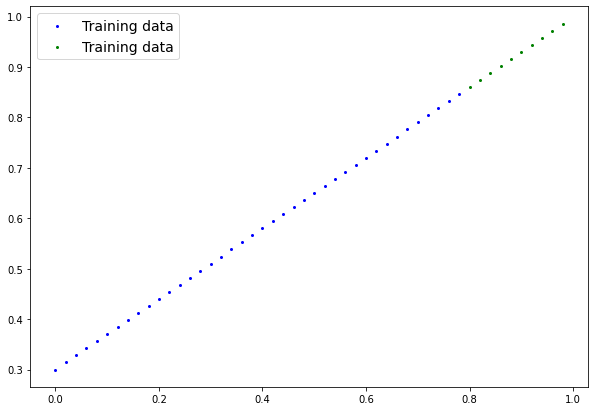

In [ ]:
plot_predictions()

## 2. Build model

Building a PyTorch model


What the model does:
* Start with random values of weight and bias
* look at the trng data and adjust the random values to get closer to the ideal values 

2 main algo to get closer to the ideal values:
* Gradient descent (attempting to find the minima of the loss function, hence requires_grad)
* Backpropagation (aims to minimize the cost function by adjusting network’s weights and biases. The level of adjustment is determined by the gradients of the cost function with respect to those parameters)

https://datascience.stackexchange.com/questions/44703/how-does-gradient-descent-and-backpropagation-work-together#:~:text=Back%2Dpropagation%20is%20the%20process,down%20through%20the%20loss%20function.

In [ ]:
#LR model using PyTorch
class LinearRegressionModel(nn.Module): #most things in PyTorch inherits from nn.Module    
  def __init__(self):
    super().__init__()
    self.weights = nn.Parameter(torch.randn(1, #start w random weight, try to adjust to ideal value
                                            requires_grad=True, #updated by gradient descent 
                                            dtype=torch.float))
    self.bias = nn.Parameter(torch.randn(1, #start w random bias, try to adjust to ideal bias
                                          requires_grad=True,
                                          dtype=torch.float))
    
  def forward(self, x: torch.Tensor) -> torch.Tensor: #every sub-class of nn.Module requires an override of forward method
      return self.weights * x + self.bias #LR formula
      

### PyTorch model building essentials
 
* torch.nn - contains all the buildings for computational graphs (nn can be considered computational graph)
* torch.nn.Parameter - what params should our model try and learn, often a PyTorch layer  from torch.nn will set this for us
* torhc.nn.Module - parent class for all nn modeuls, forward() method should be overridden
* torch.optim - this where the optimizers in PyTorch live, they will help with gradient descent
* def forward() - all nn.Module subclasses require you to overwrite forward(), this method defines what happens in the forward computation

### checking contents of PyTorch model

check model parameters using `.parameters()`

In [ ]:
#create seed
torch.manual_seed(42)

# instance of LRmodel class
model_0 = LinearRegressionModel()

#check param
print(list(model_0.parameters()))
print(model_0.state_dict())

[Parameter containing:
tensor([0.3367], requires_grad=True), Parameter containing:
tensor([0.1288], requires_grad=True)]
OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])


### making predictions  : `torch.inference_mode()`

predict y_test based on X_test

`forward()` will be used to predict when passing in data

In [ ]:
# Make predicitions with model
with torch.inference_mode(): #context manager, turns off gradient tracking.
                            #when doing inference, we are not doing training, 
                            #so we do not have to keep track of the gradient.
                            #hence PyTorch is not keeping track of useless data
                            #code and inference/predictions runs faster
  y_preds = model_0(X_test) #passing X_test data through the modell

y_preds

#torch.no_grad() disregards the "useless" data of gradient too, but inference_mode()
#is preferred (got other features)


tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

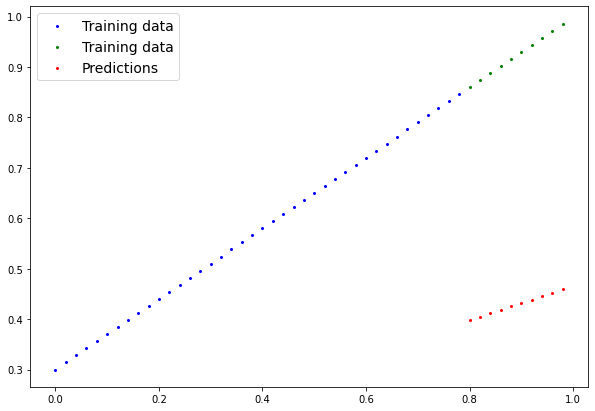

In [ ]:
plot_predictions(predictions=y_preds)

##3. Train model

The idea of training is for a model to move from some *unknown/random* params to a more accurate one.

From a poor representation to a better one

How to measure how poor the predictions are:

* Loss function
* Cost function
* Criterion

* **Loss function:** A function to measure how wrong you are, the lower, the better
* **Optimizer:** Takes into account the loss of a model and ajests the model's pararm (eg: weight and loss)
  *   params - the model parameters to optimize, for eg: params=model_0.parameters()
  *   lr(learning rate)


* Training loop
* Testing loop

In [ ]:
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True), Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [ ]:
#to see the model's parameter
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [ ]:
# set up loss function
loss_fn = nn.L1Loss()
loss_fn
# set up optimizer (stochastic gradient descent)
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.02) #learning rate = possibly the most importatnt hyperparam)


Different problems might require a different loss functions and optimizer, for example for simple regression problems like our case, L1Loss and SGD will suffice.
For problems like telling apart cat and dog a loss functino of BCELoss() might be more suitable (Binary cross entroype loss)

###Building a training loop & testing loop in PyTorch

Things needed in training loop:
0. Loop through data
1. Forward pass/propagation (involved data moving thorugh out model's `forward()` function)
2. Calculate the loss (compare forward pass predictions to ground truth labels)
3. Optimizer zero gradient
4. Loss backward (back propagation) (calculations backwards, move backwards thruogh the network to calculate the gradients of each of the parameters of our model with respect to the loss ( this is done using chain rule)  )
5. Optimizer step - using the optimizer to adjust our model's parameters to try and improve the loss (gradient descent)



In [ ]:
# epoch is one loop through the data
epochs = 100

epoch_count = []
loss_values = []
test_loss_values = []

### Training
#step 0, loop through the data
for epochs in range(epochs):
  #set the model to training mode
  model_0.train() #train mode in PyTroch sets all params that requires gradient to require gradient

  #1. forward pass
  y_pred = model_0(X_train) # learning patterns to predict

  #2. Loss function
  loss = loss_fn(y_pred, y_train) #difference between prediction and ideal 
  #3. Optimizer zero grad
  optimizer.zero_grad()

  #4. Back propagation on the loss wrt the params of the model
  loss.backward()

  #5. Step the optimizer (perform gradient descent)
  optimizer.step() #by default how the optimizer changes will accumulate through the loop. 
                  #so we have to zero them in step 3 (start from afresh).

  # testing
  model_0.eval() #turns off gradient tracking/ things not needed for eval/testing
  with torch.inference_mode():
    #1. forward pass
    test_pred = model_0(X_test)

    #2. calc the loss
    test_loss = loss_fn(test_pred, y_test)

  if epochs % 10 == 0:
    epoch_count.append(epochs)
    loss_values.append(loss)
    test_loss_values.append(test_loss)
    print(f"Epoch: {epochs} | Loss: {loss} | Test loss: {test_loss}")

print(f"loss is {loss}")


Epoch: 0 | Loss: 0.31288138031959534 | Test loss: 0.4675941467285156
Epoch: 10 | Loss: 0.08831816911697388 | Test loss: 0.20536987483501434
Epoch: 20 | Loss: 0.04547790437936783 | Test loss: 0.11100725829601288
Epoch: 30 | Loss: 0.03829658776521683 | Test loss: 0.08761118352413177
Epoch: 40 | Loss: 0.031427789479494095 | Test loss: 0.072440005838871
Epoch: 50 | Loss: 0.02456694096326828 | Test loss: 0.055895041674375534
Epoch: 60 | Loss: 0.017689326778054237 | Test loss: 0.03935007005929947
Epoch: 70 | Loss: 0.010823884978890419 | Test loss: 0.024178892374038696
Epoch: 80 | Loss: 0.003965773619711399 | Test loss: 0.006277936510741711
Epoch: 90 | Loss: 0.01409052312374115 | Test loss: 0.005287045147269964
loss is 0.008951482363045216


In [ ]:
loss_values, test_loss_values

([tensor(0.3129, grad_fn=<MeanBackward0>),
  tensor(0.0883, grad_fn=<MeanBackward0>),
  tensor(0.0455, grad_fn=<MeanBackward0>),
  tensor(0.0383, grad_fn=<MeanBackward0>),
  tensor(0.0314, grad_fn=<MeanBackward0>),
  tensor(0.0246, grad_fn=<MeanBackward0>),
  tensor(0.0177, grad_fn=<MeanBackward0>),
  tensor(0.0108, grad_fn=<MeanBackward0>),
  tensor(0.0040, grad_fn=<MeanBackward0>),
  tensor(0.0141, grad_fn=<MeanBackward0>)],
 [tensor(0.4676),
  tensor(0.2054),
  tensor(0.1110),
  tensor(0.0876),
  tensor(0.0724),
  tensor(0.0559),
  tensor(0.0394),
  tensor(0.0242),
  tensor(0.0063),
  tensor(0.0053)])

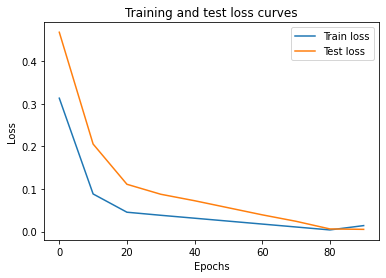

In [ ]:
#plot loss curves
import numpy as np
plt.plot(epoch_count, np.array(torch.tensor(loss_values).numpy()), label="Train loss")
plt.plot(epoch_count, np.array(torch.tensor(test_loss_values).numpy()), label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()

In [ ]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.6849])), ('bias', tensor([0.2918]))])

In [ ]:
with torch.inference_mode(): #turns off gradient tracking
  y_preds_new = model_0(X_test)

y_preds_new

tensor([[0.8397],
        [0.8534],
        [0.8671],
        [0.8808],
        [0.8945],
        [0.9082],
        [0.9219],
        [0.9356],
        [0.9493],
        [0.9630]])

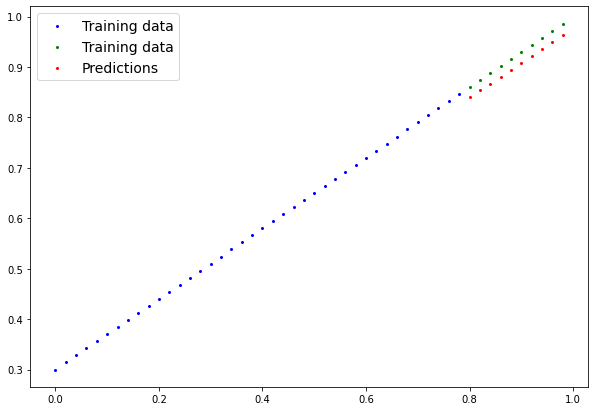

In [ ]:
plot_predictions(predictions=y_preds_new)

##Saving a model in PyTorch

3 main ways to save and load a model:

1. `torch.save()` - save a model (PyTorch object) in pickle format
2. `torch.load()` - load a saved PyTorch object
3. `torch.nn.Module.load_state_dict()` - load a model's saved state dict

In [ ]:
# Saving PyTorch model
from pathlib import Path

# 1. Model dir
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Model save path
MODEL_NAME = "01_pytorch_workflow_model_0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. SAve a model's state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(),
           f=MODEL_SAVE_PATH)


Saving model to: models/01_pytorch_workflow_model_0.pth


In [ ]:
!ls -1 models

01_pytorch_workflow_model_0.pth


## Loading a PyTorch model

Having saved the model's `state_dict()`, we can create a new instance of our model and load the saved `state_dict()` in

In [ ]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.6849])), ('bias', tensor([0.2918]))])

In [ ]:
# instatiate a new instance of model class
loaded_model_0 = LinearRegressionModel()

# load the saved state_dict in, else it will be random
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

In [ ]:
loaded_model_0.state_dict()

OrderedDict([('weights', tensor([0.6849])), ('bias', tensor([0.2918]))])

In [ ]:
# make some predictions
loaded_model_0.eval()
with torch.inference_mode():
  loaded_model_preds = loaded_model_0(X_test)

loaded_model_preds

tensor([[0.8397],
        [0.8534],
        [0.8671],
        [0.8808],
        [0.8945],
        [0.9082],
        [0.9219],
        [0.9356],
        [0.9493],
        [0.9630]])

In [ ]:
y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

In [ ]:
model_0.eval()
with torch.inference_mode():
  y_preds = model_0(X_test)

y_preds

tensor([[0.8397],
        [0.8534],
        [0.8671],
        [0.8808],
        [0.8945],
        [0.9082],
        [0.9219],
        [0.9356],
        [0.9493],
        [0.9630]])

In [ ]:
y_preds == loaded_model_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

## 6. Summary of a workflow



In [ ]:
#import PyTorch and matplotlib
import torch
from torch import nn
import matplotlib.pyplot as plt

#check PyTorch vers
torch.__version__

'1.13.1+cu116'

Create device-agnostic code

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


### 6.1 Data

In [ ]:
#create data using linear regression formula
weight = 0.7
bias = 0.3

#range values
start = 0
end = 1
step = 0.02

# X and y (feature and labels)
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias


In [ ]:
# train-test split
train_split = int(0.8* len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]
len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

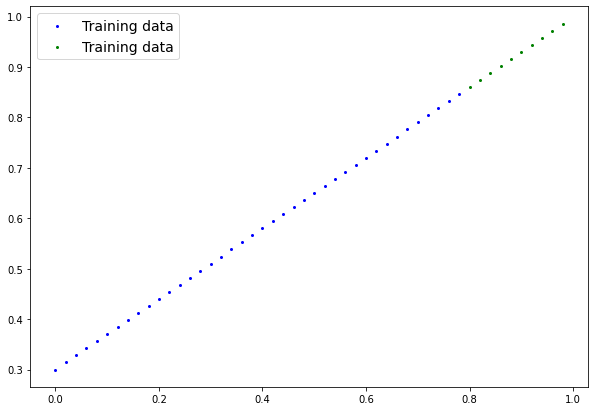

In [ ]:
plot_predictions(X_train, y_train, X_test, y_test)

###  6.2 Building a PyTorch Linear model

In [ ]:
# Create a linear model by subclassing nn.Module

class LinearRegressionModelV2(nn.Module):
  
  def __init__(self):
    super().__init__()
    #nn.Linear() creates the model params, also called linear transform, probing layer, fully connected layer etc
    self.linear_layer = nn.Linear(in_features=1,  #nn.Linear applies the y = weight*X + bias formula, self.weight, self.bias params are initialised 
                                  out_features=1) #what goes in and comes out

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.linear_layer(x)

#set manual seed
torch.manual_seed(42)
model_1 = LinearRegressionModelV2()
model_1, model_1.state_dict()


(LinearRegressionModelV2(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]))

In [ ]:
X_train[:5], y_train[:5]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800]]), tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560]]))

In [ ]:
# check model device
next(model_1.parameters()).device

device(type='cpu')

In [ ]:
#set model to use target device
model_1.to(device)
next(model_1.parameters()).device

device(type='cuda', index=0)

### 6.3 Training

For training:
* Loss function
* Optimizer
* Training Loop
* Testing Loop




In [ ]:
# setup loss fn
loss_fn = nn.L1Loss() #MAE

# setup optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr=0.01)  #stochastic gradient descent

In [ ]:
#training loop
torch.manual_seed(42)

epochs = 200

# set data to target device

X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

for epoch in range(epochs):
  model_1.train()

  #1. forward pass
  y_pred = model_1(X_train) #data is in cpu, remember to change it 

  #2. calc loss
  loss = loss_fn(y_pred, y_train)

  #3. Optimizer zero grad 
  optimizer.zero_grad()

  #4. backpropagation
  loss.backward()

  #5. Optimizer step
  optimizer.step()

  ## Testing
  model_1.eval()
  with torch.inference_mode():
    test_pred = model_1(X_test)

    test_loss = loss_fn(test_pred, y_test)

  if epoch % 10 == 0:
    print(f"Epoch: {epoch} | Loss: {loss} | Test Loss: {test_loss}")



Epoch: 0 | Loss: 0.5551779866218567 | Test Loss: 0.5739762187004089
Epoch: 10 | Loss: 0.439968079328537 | Test Loss: 0.4392664134502411
Epoch: 20 | Loss: 0.3247582018375397 | Test Loss: 0.30455657839775085
Epoch: 30 | Loss: 0.20954833924770355 | Test Loss: 0.16984669864177704
Epoch: 40 | Loss: 0.09433845430612564 | Test Loss: 0.03513690456748009
Epoch: 50 | Loss: 0.023886388167738914 | Test Loss: 0.04784907028079033
Epoch: 60 | Loss: 0.019956795498728752 | Test Loss: 0.045803118497133255
Epoch: 70 | Loss: 0.016517987474799156 | Test Loss: 0.037530567497015
Epoch: 80 | Loss: 0.013089174404740334 | Test Loss: 0.02994490973651409
Epoch: 90 | Loss: 0.009653178043663502 | Test Loss: 0.02167237363755703
Epoch: 100 | Loss: 0.006215683650225401 | Test Loss: 0.014086711220443249
Epoch: 110 | Loss: 0.00278724217787385 | Test Loss: 0.005814164876937866
Epoch: 120 | Loss: 0.0012645035749301314 | Test Loss: 0.013801801018416882
Epoch: 130 | Loss: 0.0012645035749301314 | Test Loss: 0.013801801018416

In [ ]:
model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.6968]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.3025], device='cuda:0'))])

### 6.4 Prediction and evaluation

In [ ]:
#turn on eval mode
model_1.eval()

#predictions
with torch.inference_mode():
  y_preds = model_1(X_test)

y_preds

tensor([[0.8600],
        [0.8739],
        [0.8878],
        [0.9018],
        [0.9157],
        [0.9296],
        [0.9436],
        [0.9575],
        [0.9714],
        [0.9854]], device='cuda:0')

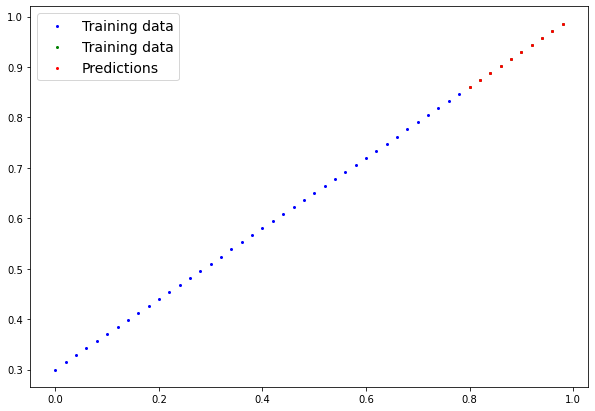

In [ ]:
# visualize
plot_predictions(predictions=y_preds.cpu())

### Saving and loading a trained model

In [ ]:
from pathlib import Path
# 1. Creat models dir
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create models save path
MODEL_NAME = "01_pytorch_workflow_model_1.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

#3. save the model state dict
print(f"Saving model to : {MODEL_SAVE_PATH}")
torch.save(obj=model_1.state_dict(),
           f=MODEL_SAVE_PATH)


Saving model to : models/01_pytorch_workflow_model_1.pth


In [ ]:
# Load a pytorch model
loaded_model_1 = LinearRegressionModelV2()


#load the saved model's state_dict
loaded_model_1.load_state_dict(torch.load(MODEL_SAVE_PATH))

# put the loaded model to device
loaded_model_1.to(device)



LinearRegressionModelV2(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)

In [ ]:
loaded_model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.6968]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.3025], device='cuda:0'))])

In [ ]:
loaded_model_1.eval()
with torch.inference_mode():
  loaded_model_1_preds = loaded_model_1(X_test)

y_preds == loaded_model_1_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]], device='cuda:0')